Import necessary library

In [61]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

Define needed variable:
IMAGE_SIZE: the size of the image 256 * 256
BATCH_SIZE: the number of image in each batch
EPOCHS: the number of times to train the model
CHANNELS: RGB

In [62]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3

Load images to dataset

In [63]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../dataImage/",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1125 files belonging to 15 classes.


The size of the dataset, which makes sense. 1125 < 32*36 = 1152 < 1157.

In [64]:
len(dataset)

36

The class name which will be used later

In [65]:
class_name = dataset.class_names
class_name

['Acer',
 'Alnus incana',
 'Betula pubescens',
 'Fagus silvatica',
 'Populus',
 'Populus tremula',
 'Quercus',
 "Salix alba 'Sericea'",
 'Salix aurita',
 'Salix sinerea',
 'Sorbus aucuparia',
 'Sorbus intermedia',
 'Tilia',
 'Ulmus carpinifolia',
 'Ulmus glabra']

Print the image samples in the first batch

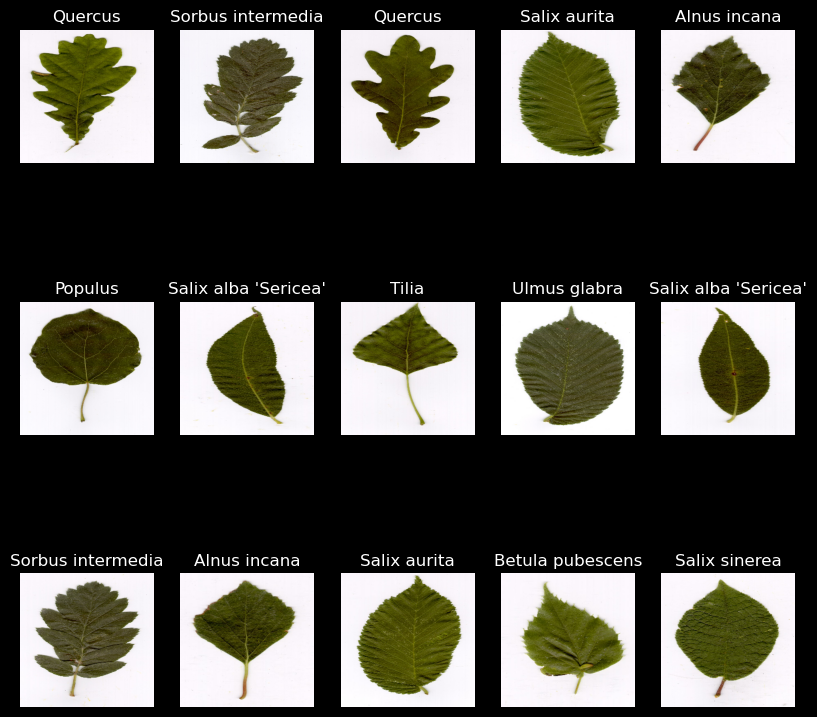

In [66]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(15):
        plt.subplot(3,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")

Divide dataset into train_ds, validation_ds, and test_ds

In [67]:
int(len(dataset) * 0.7)

25

In [68]:
train_ds = dataset.take(25)
val_ds = dataset.skip(25).take(6)
test_ds = dataset.skip(25).skip(6)
print(f"the size of train_ds {len(train_ds)} \nthe size of val_ds {len(val_ds)} \nthe size of test_ds {len(test_ds)}")

the size of train_ds 25 
the size of val_ds 6 
the size of test_ds 5


Better the performance of the code

In [69]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

Change the size of the image to fit the model whose range is [0,1]

In [70]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
    
])

Use data augmentation to produce more images and prevent overfitting

In [71]:
data_augmentation = tf.keras.Sequential([
    #layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    #layers.experimental.preprocessing.RandomRotation(0.2)
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.1),
])

Build the CNN models with different layers 

In [72]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE)),
    layers.MaxPooling2D((2,2)),
    #layers.Conv2D(32, (3,3), activation='relu'),
    #layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    #layers.Conv2D(64, (3,3), activation='relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE)),
    layers.MaxPooling2D((2,2)),
    #layers.Dropout(0.3),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    #layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    
    #layers.Conv2D(256, (3,3), activation='relu'),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    
    #layers.Conv2D(512, (3,3), activation='relu'),
    #layers.MaxPooling2D((2,2)),
    #layers.Dropout(0.3),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape= input_shape)

In [73]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 sequential_11 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_33 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_33 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (32, 127, 127, 32)        0         
                                                                 
 conv2d_34 (Conv2D)          (32, 125, 125, 64)        18496     
                                                     

In [74]:
#base_learning_rate = 0.001
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [75]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data=val_ds
)

Epoch 1/50


c:\Users\x2421\miniconda3\envs\tf\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


25/25 [==============================] - 23s 743ms/step - loss: 2.7078 - accuracy: 0.0700 - val_loss: 2.6877 - val_accuracy: 0.0781
Epoch 2/50
25/25 [==============================] - 17s 668ms/step - loss: 2.4478 - accuracy: 0.1825 - val_loss: 2.3571 - val_accuracy: 0.2292
Epoch 3/50
25/25 [==============================] - 17s 674ms/step - loss: 2.0329 - accuracy: 0.2812 - val_loss: 1.9837 - val_accuracy: 0.2969
Epoch 4/50
25/25 [==============================] - 17s 676ms/step - loss: 1.8392 - accuracy: 0.3475 - val_loss: 1.7161 - val_accuracy: 0.4010
Epoch 5/50
25/25 [==============================] - 17s 673ms/step - loss: 1.6740 - accuracy: 0.4000 - val_loss: 1.5517 - val_accuracy: 0.5469
Epoch 6/50
25/25 [==============================] - 16s 659ms/step - loss: 1.4675 - accuracy: 0.4700 - val_loss: 1.3867 - val_accuracy: 0.5260
Epoch 7/50
25/25 [==============================] - 17s 663ms/step - loss: 1.3302 - accuracy: 0.5163 - val_loss: 1.2427 - val_accuracy: 0.6875
Epoch 8/50

In [76]:
acc = history.history['accuracy']
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

Print the accuracy and loss curve to see whether the model is overfitting or underfitting.
Method for overfitting:
1, use dropout in the models
2, use different learning rate
3, data augmentation
4, change the models

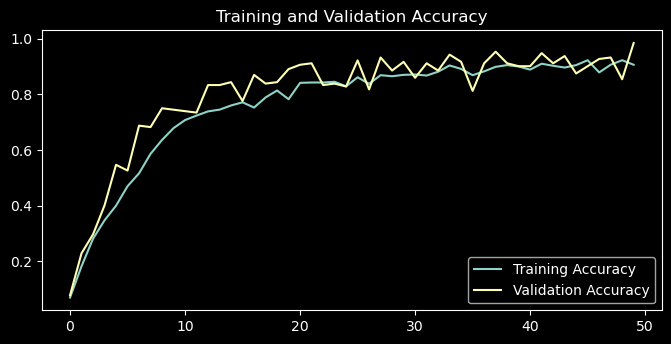

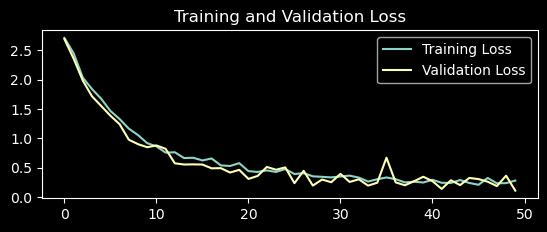

In [77]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,2)
plt.plot(range(EPOCHS), acc, label = "Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")
plt.show()

plt.subplot(2,1,2)
plt.plot(range(EPOCHS), loss, label = "Training Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")
plt.show()

In [78]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 25ms/step


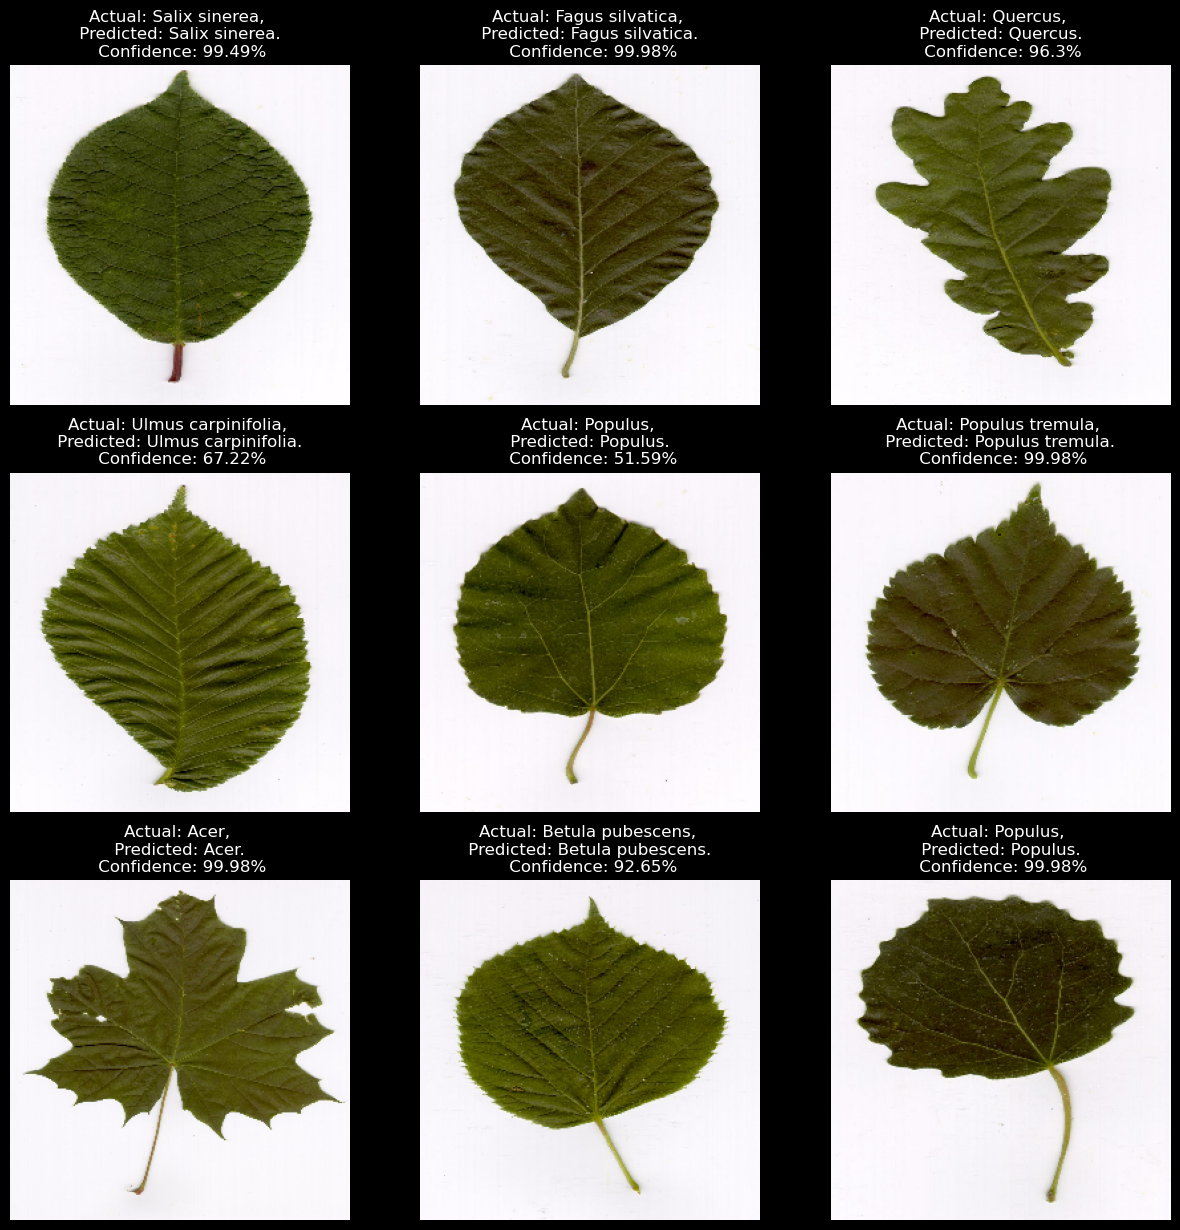

In [84]:
predicted = []
true = []
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")
        plt.axis("off")

Be prepared for model evaluation

In [85]:
predicted = []
true = []

for images, labels in test_ds.take(5):
    for i in range(len(images)):
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]]
        predicted.append(predicted_class)
        true.append(actual_class)


1/1 [==============================] - 0s 25ms/step


In [86]:
print(true[0], predicted[0])

Ulmus glabra Ulmus glabra


Print the confusion matrix for each class and get f1-score to see the accuracy of the model

In [87]:
import sklearn.metrics as skm
matrix = skm.multilabel_confusion_matrix(true, predicted)
print(matrix)
print( skm.classification_report(true,predicted))

[[[121   0]
  [  0  12]]

 [[131   0]
  [  0   2]]

 [[122   0]
  [  0  11]]

 [[123   0]
  [  0  10]]

 [[124   1]
  [  0   8]]

 [[125   0]
  [  0   8]]

 [[124   0]
  [  1   8]]

 [[123   0]
  [  0  10]]

 [[124   1]
  [  0   8]]

 [[122   0]
  [  0  11]]

 [[121   0]
  [  0  12]]

 [[126   1]
  [  0   6]]

 [[126   0]
  [  1   6]]

 [[125   0]
  [  1   7]]

 [[122   0]
  [  0  11]]]
                      precision    recall  f1-score   support

                Acer       1.00      1.00      1.00        12
        Alnus incana       1.00      1.00      1.00         2
    Betula pubescens       1.00      1.00      1.00        11
     Fagus silvatica       1.00      1.00      1.00        10
             Populus       0.89      1.00      0.94         8
     Populus tremula       1.00      1.00      1.00         8
             Quercus       1.00      0.89      0.94         9
Salix alba 'Sericea'       1.00      1.00      1.00        10
        Salix aurita       0.89      1.00      0.94

Print the confusion matrix

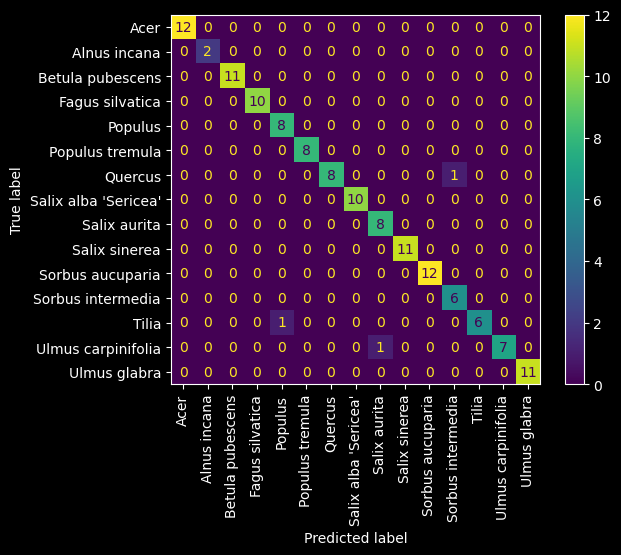

In [88]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_true=true, y_pred=predicted, labels=class_name, xticks_rotation="vertical"
)